In [1]:
# %matplotlib notebook

from matplotlib import pylab
from astropy.coordinates import SkyCoord
import integralclient as ic

import time
import numpy as np

from astropy.table import Table, vstack
from astropy.io import fits
import glob
from scipy import stats
from astropy.time import Time

failed to get AUTH with env due to: 'K8S_SECRET_INTEGRAL_CLIENT_SECRET'
got AUTH with homefile for integral-limited


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
RA=293.732
Dec=21.8967222
tstart_rel_mseconds=300.0
tstop_rel_seconds=300.0
# t0_utc="2023-05-18T12:59:08.000000" 
# t0_utc=Time(Time("2022-10-14T19:21:47").mjd - 8.632259375000002/24/3600, format='mjd').isot.replace(" ", "T") # hard x-ray
# t0_utc="2022-10-14T19:21:47"
# rt=1
nrt=1
arc=0
required_completeness=0.6
# mode="rt" # scw|rt|arc
mode="scw" # scw|rt|arc
global_snr_threshold=3.
negative_excesses=0

In [3]:
t0_utc

'2017-08-17T12:41:04.4'

In [4]:
if mode == "scw":
    rt=0
    nrt=1
    arc=0
elif mode == "rt":
    rt=1
    nrt=0
    arc=0
elif mode == "arc":
    rt=0
    nrt=0
    arc=1
elif mode == "flags":
    print("mode set by flags")
else:
    raise Exception("unknown mode: {}, allowed: scw, rt".format(mode))

In [5]:
source_coord = SkyCoord(RA, Dec, unit = "deg")

In [6]:
import importlib

In [7]:
# /home/savchenk/work/transients/workflows/integral-all-sky

import integralenv
importlib.reload(integralenv)

arc_root_prefix = integralenv.get_arc_root_prefix()

In [8]:
now_ijd = float(ic.converttime("UTC",time.strftime("%Y-%m-%dT%H:%M:%S"),"IJD"))
t0_ijd =  float(ic.converttime("UTC",t0_utc,"IJD"))

tstart_ijd = t0_ijd - tstart_rel_mseconds/24./3600
tstop_ijd = t0_ijd + tstop_rel_seconds/24./3600

now_ijd, t0_ijd, tstart_ijd, tstop_ijd

2023-05-19 16:37:24 savchenk-NG-VN7-793G-79EG root[1729697] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2023-05-19T16:37:24/IJD
2023-05-19 16:37:25 savchenk-NG-VN7-793G-79EG root[1729697] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/UTC/2017-08-17T12:41:04.4/IJD


(8539.69343962963, 6438.529323888889, 6438.525851666666, 6438.532796111112)

In [9]:
lcs={}


In [10]:
if nrt == 1:
    import isdcclient

    IC = isdcclient.ISDCClient()

    
    lcs['ACS'] = IC.genlc("ACS", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    lcs['ACS'][:,1] = 0.05
    print("got ACS", lcs['ACS'])
    
    #lcs['IBIS/Veto'] = IC.genlc("IBIS_VETO", t0_utc, "%.10lg"%max(tstart_rel_mseconds,tstop_rel_seconds),format='numpy')
    #lcs['IBIS/Veto'][:,1] = 8.

import requests


if rt == 1:
    r = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/rtlc/{t0_utc}/{tstop_rel_seconds}?json")
    lc = np.array(r.json()['data'])
    lcs['ACS'] = np.vstack([lc[:,1], lc[:,1] * 0 + 0.05, lc[:,0]]).T

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/integralhk/api/v1.0/genlc/ACS/2017-08-17T12:41:04.4/300
got ACS [[6.43852585e+03 5.00000000e-02 5.63000000e+03 4.53644244e+04]
 [6.43852585e+03 5.00000000e-02 5.78400000e+03 4.53644744e+04]
 [6.43852585e+03 5.00000000e-02 5.74000000e+03 4.53645244e+04]
 ...
 [6.43853279e+03 5.00000000e-02 5.69800000e+03 4.59642749e+04]
 [6.43853280e+03 5.00000000e-02 5.62800000e+03 4.59643249e+04]
 [6.43853280e+03 5.00000000e-02 5.73200000e+03 4.59643749e+04]]


(-5.0, 5.0)

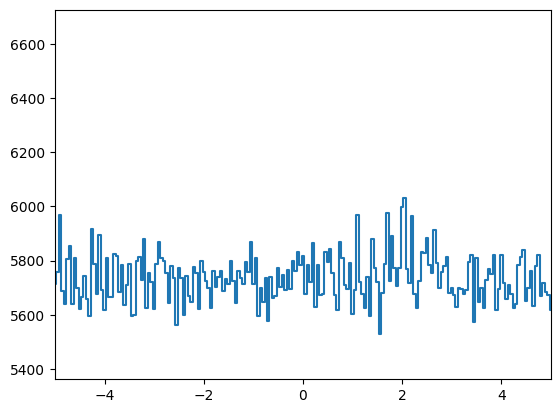

In [11]:
from matplotlib import pylab as plt

plt.figure()

plt.step(
    (lcs['ACS'][:,0] - t0_ijd)*24*3600,
    lcs['ACS'][:,2],
)

plt.xlim(-5,5)

In [12]:
def rebin(lc,n,av = False):
    if n == 0: return lc
    
    N=int(lc.shape[0]/n)*n
    if av:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).mean(1)
    else:
        return lc[:N].reshape((int(lc.shape[0]/n), n)).sum(1)

In [13]:
import re
import time

# if rt == 1:

#     got_data = False
    
#     while not got_data:
#         current_rev=float(ic.converttime("UTC",t0_utc,"REVNUM"))

#         print("current rev", current_rev)

#         rtdata_roots=[
#             '/unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',
#             '/rtdata',
#             '/mnt/sshfs/isdc-in01//unsaved/astro/savchenk/dockers/realtimeacs/docker-ibas/spiacs-lcdump',    
#         ]

#         for realtime_dump_root in rtdata_roots + [ None ]:
#             #print("probing",realtime_dump_root,"with",glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))
#             if realtime_dump_root and len(glob.glob(realtime_dump_root+"/lcdump-revol-*.csv"))>0:
#                 print("this",realtime_dump_root)
#                 break

#         if not realtime_dump_root:
#             raise Exception("no realtime archvie found")

#         for rt_fn in reversed(sorted([l for l in glob.glob(realtime_dump_root+"/lcdump-revol-*.csv") if 
#                        float(re.search("lcdump-revol-(\d{4}).*.csv",l).groups()[0])<=current_rev+1])):

#             print(rt_fn)

#             rt_lc = np.genfromtxt(rt_fn)

#             lcs['ACS']=rt_lc[:,(3,0,2,0)]
#             lcs['ACS'][:,1] = 0.05

#             first_data = lcs['ACS'][:,0][0]
#             last_data = lcs['ACS'][:,0][-1]

#             print("now", now_ijd, 
#                   "first data in file", first_data, 
#                   "last data", last_data, 
#                   "requested", t0_ijd, 
#                   "have margin", (last_data-t0_ijd)*24*3600,"s",
#                   "data delay", (now_ijd-last_data)*24*3600,"s")       


#             if t0_ijd<first_data:
#                 print("data in the previous file")
#                 continue
                

#             print("margin",(last_data-now_ijd)*24*3600-tstop_rel_seconds*1.5 + 100)
#             if  (last_data-t0_ijd)*24*3600>tstop_rel_seconds*1.5 + 100:                            
#                 print("this margin is sufficient")
#                 got_data=True
#                 break
#             else:
#                 print("this margin is NOT sufficient, waiting")
#             #    if (now_ijd-last_data)*24*3600>1000:
#             #        raise RuntimeError('margin insufficent, data too old: no more hope')                

#                 time.sleep(30)
#                 break
        
            
            

    

In [14]:
# lcs['ACS']

lcs['ACS'][:,0].min()

6438.525851949507

total lc (12000, 4)
min -0.003471939381597622
max 0.00347193173274718
expected telapse 600.0 telapse 599.9504642793909 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
b_tb 0.05000000000000001
acceptable, will be 1 0.05000000000000001
rebinned to (12000,)
{'meanrate': 114581.72666666664, 'maxrate': 133279.99999999997, 'stdvar': 1699.1729611653864, 'meanerr': 1513.814563720845, 'excvar': 1.1224445859398684, 'maxsnr': 10.203263552234729, 'localfar': 1.1503186123706418e-20, 'localfar_s': 9.321199970915421}
requested scale 0.5
b_tb 0.05000000000000001
acceptable, will be 9 0.45000000000000007
rebinned to (1333,)
{'meanrate': 114581.9421522047, 'maxrate': 116373.33333333331, 'stdvar': 582.5586430832174, 'meanerr': 504.60532906025713, 'excvar': 1.1544837312125402, 'maxsnr': 3.0512805057555163, 'localfar': 1.5187374528401274, 'localfar_s': 0}
requested scale 1
b_tb 0.05000000000000001
acceptable, will be 19 0.9500000000000002
rebinned to (631,)
{'meanrate': 114581.326215

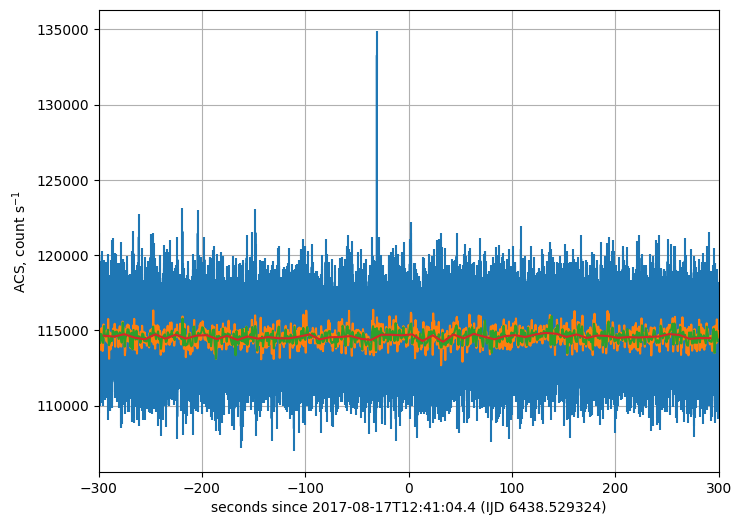

In [15]:
summary = dict()    

for n, lc in lcs.items():

    try:
        rel_s = (lc[:,0]-t0_ijd)*24*3600
    except:
        continue

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds

    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)

    lc = lc[m]

    b_tb = np.mean(lc[:,1])    

    rel_s = (lc[:,0]-t0_ijd)*24*3600

    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    

    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])


    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)

    if float(ontime) / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg completeness %s requireed %s"%(
            expected_telapse, telapse, ontime,
            ontime / expected_telapse, required_completeness))

    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary

    print("size", lc.shape, rel_s.shape)

    if np.sum(m) == 0: continue

    pylab.figure(figsize=(8,6))


    for ascale in [0.05, 0.5, 1, 10]:
        summary_scale = dict()
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = summary_scale        


        print("requested scale",ascale)
        print("b_tb",b_tb)

        if b_tb>ascale:
            ascale = b_tb


        nscale = int(ascale/b_tb)
        scale=nscale*b_tb

        print("acceptable, will be", nscale, scale)

        rate = rebin(lc[:,2],nscale,False)/scale
        rate_err = rebin(lc[:,2],nscale,False)**0.5/scale

        print("rebinned to",rate.shape)

        pylab.errorbar(
            rebin(rel_s,nscale,True),
            rate,
            rate_err,
            xerr=scale/4.
        )

        summary_scale['meanrate'] = np.mean(rate)
        summary_scale['maxrate'] = np.max(rate)
        summary_scale['stdvar'] = np.std(rate)
        summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
        summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

        summary_scale['maxsnr'] = np.max((rate-np.mean(rate))/rate_err/summary_scale['excvar'])

        summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

        summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0

        # add FAR spike here

        if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
            lc_summary['best'] = dict(
                localfar_s = summary_scale['localfar_s'],
                scale = ascale,
            )

        print(summary_scale)


    #tight_layout()
    pylab.grid()

    pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", count s$^{-1}$")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))

    fn=n.replace("/","_") + "_lc.png"
    pylab.savefig(fn)
    print("saving as",fn)
    break


In [16]:
# below S/N of 4 FAR is determined primarily by poisson, above - by spikes

def approx_FAR_spike_hz(snr, scale):    
    lim_snr = 2
    
    spike_rate_snr6 = 60./3600./24.
    if scale>=0.1:
        spike_rate_snr6*=(scale/0.1)**-1
    
    
    approx_FAR_hz = snr*0 + spike_rate_snr6 * (lim_snr/6.)**-2.7 
    
    try:
        if snr>lim_snr:
            approx_FAR_hz = spike_rate_snr6 * (np.abs(snr)/6.)**-2.7
    except:
        m=snr>lim_snr
        approx_FAR_hz[m] = (np.abs(snr[m])/6.)**-2.7 * spike_rate_snr6
        

    return approx_FAR_hz

def approx_FAR_norm_hz(snr, scale_s):
    return stats.norm.sf(snr)/scale_s

def approx_FAP(snr, t, scale_s):
    
    try:
        t_scaled = t[:]
        t_scaled[abs(t)<scale_s]=scale_s
    except:
        if abs(t)<scale_s:
            t_scaled=scale_s
        else:
            t_scaled=t

    approx_FAP = 2 * ( approx_FAR_norm_hz(snr, scale_s) + approx_FAR_spike_hz(snr, scale_s) )  * abs(t_scaled) * (1+np.log( 30/0.1))
    
    return approx_FAP



(1e-05, 30)

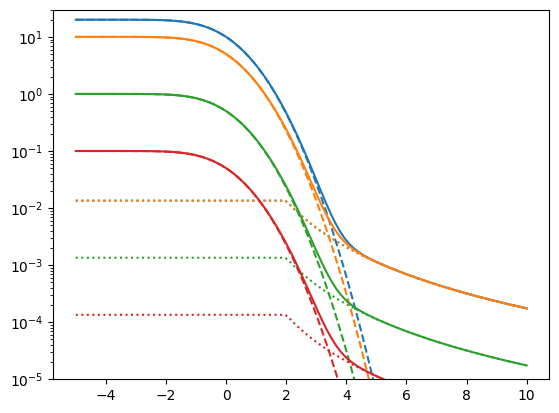

In [17]:
pylab.figure()

x=np.linspace(-5,10,100)

for scale_s in 0.05, 0.1, 1, 10:

    c=pylab.plot(x,approx_FAR_norm_hz(x, scale_s), ls='--')
    pylab.plot(x,approx_FAR_spike_hz(x, scale_s),c=c[0].get_color(),ls=":")
    pylab.plot(x,
               approx_FAR_spike_hz(x, scale_s) + approx_FAR_norm_hz(x, scale_s),
               c=c[0].get_color()
              )


    pylab.semilogy()

pylab.ylim([1e-5, 30])


In [18]:
timescales = sorted(set([0.05*ns for ns in sorted(set(
    list(map(int,np.logspace(0,np.log10(20*30),100))) 
))]  + list(np.linspace(1,31,30*2+1))))
timescales

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.30000000000000004,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.65,
 0.7000000000000001,
 0.75,
 0.8,
 0.8500000000000001,
 0.9,
 0.9500000000000001,
 1.0,
 1.1,
 1.1500000000000001,
 1.25,
 1.3,
 1.4000000000000001,
 1.5,
 1.6,
 1.7000000000000002,
 1.85,
 1.9500000000000002,
 2.0,
 2.1,
 2.25,
 2.4000000000000004,
 2.5,
 2.5500000000000003,
 2.7,
 2.9000000000000004,
 3.0,
 3.1,
 3.3000000000000003,
 3.5,
 3.5500000000000003,
 3.75,
 4.0,
 4.3,
 4.5,
 4.6000000000000005,
 4.9,
 5.0,
 5.2,
 5.5,
 5.550000000000001,
 5.95,
 6.0,
 6.3500000000000005,
 6.5,
 6.75,
 7.0,
 7.2,
 7.5,
 7.7,
 8.0,
 8.200000000000001,
 8.5,
 8.75,
 9.0,
 9.35,
 9.5,
 10.0,
 10.5,
 10.65,
 11.0,
 11.350000000000001,
 11.5,
 12.0,
 12.100000000000001,
 12.5,
 12.950000000000001,
 13.0,
 13.5,
 13.8,
 14.0,
 14.5,
 14.700000000000001,
 15.0,
 15.5,
 15.700000000000001,
 16.0,
 16.5,
 16.75,
 17.0,
 17.5,
 17.85,
 18.0,
 18.5,
 19.0,
 1

total lc (12000, 4)
min -0.003471939381597622
max 0.00347193173274718
expected telapse 600.0 telapse 599.9504642793909 ontime 600.0000000000001
size (12000, 4) (12000,)
requested scale 0.05
true scale 0.05000000000000001
offset 0 rebinned to (12000,)
summary_scale['excvar'] 1.1224445859398684
5385 10.203263552234729 -30.725353391608223
scale 0.05000000000000001 offset 0 found excesses 18
requested scale 0.1
true scale 0.10000000000000002
offset 0 rebinned to (6000,)
summary_scale['excvar'] 1.1262615353792074
2692 7.140781390159192 -30.750354002520908
scale 0.10000000000000002 offset 0 found excesses 12
offset 1 rebinned to (5999,)
summary_scale['excvar'] 1.136125886578265
2692 7.109182496862692 -30.700353723659646
scale 0.10000000000000002 offset 1 found excesses 13
requested scale 0.15000000000000002
true scale 0.15000000000000002
offset 0 rebinned to (4000,)
summary_scale['excvar'] 1.1399537878278214
1795 4.994104429176186 -30.675353453261778
scale 0.15000000000000002 offset 0 found 

{'localfar_s': 9.321199970915421,
 'scale': 0.05000000000000001,
 'summary_scale': {'scale_s': 0.05000000000000001,
  'meanrate': 114581.72666666664,
  'maxrate': 133279.99999999997,
  'stdvar': 1699.1729611653864,
  'meanerr': 1513.814563720845,
  'excvar': 1.1224445859398684,
  'maxsnr': 10.203263552234729,
  'maxsnr_t': -30.725353391608223,
  'localfar': 1.1503186123706418e-20,
  'localfar_s': 9.321199970915421,
  'excesses': [{'snr': 3.070966576816289,
    'rel_s_scale': -299.52556336065754,
    'rate': 119919.99999999997,
    'rate_err': 1548.676854608475,
    'rate_overbkg': 5338.273333333331,
    'FAP': 102.69948397487316},
   {'snr': 3.1609023474820317,
    'rel_s_scale': -266.27553790749516,
    'rate': 120079.99999999997,
    'rate_err': 1549.709650224841,
    'rate_overbkg': 5498.273333333331,
    'FAP': 70.1416971149837},
   {'snr': 3.787158505757924,
    'rel_s_scale': -261.12553181592375,
    'rate': 121199.99999999997,
    'rate_err': 1556.9200364822848,
    'rate_overbk

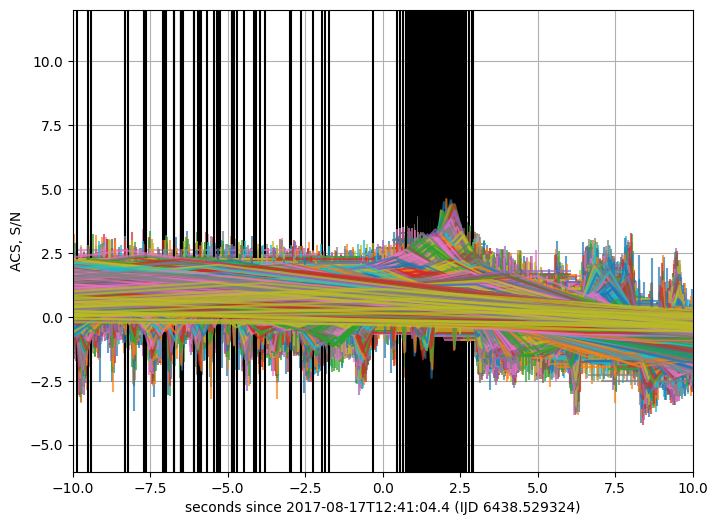

In [19]:
summary = dict()    
all_excesses=[]            

best_lc=None

for n, lc in lcs.items():
    
    #rel_s = lc[:,0]
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    

    m = rel_s>-tstart_rel_mseconds
    m &= rel_s<tstop_rel_seconds
    
    print("total lc",lc.shape)
    print("min",lc[:,0].min()-t0_ijd)
    print("max",lc[:,0].max()-t0_ijd)
    
    lc = lc[m]
   # rel_s = lc[:,0]
    
    b_tb = np.mean(lc[:,1])    
    
    rel_s = (lc[:,0]-t0_ijd)*24*3600
    
    expected_telapse = tstop_rel_seconds + tstop_rel_seconds    
    
    if len(rel_s) == 0:
        telapse = 0
        ontime = 0
    else:
        telapse = rel_s.max() - rel_s.min()
        ontime = np.sum(lc[:,1])
        
    
    print("expected telapse", expected_telapse, "telapse", telapse, "ontime", ontime)
    
    if ontime / expected_telapse < required_completeness:
        raise Exception("data not available: exected %.5lg elapsed %.5lg ontime %.5lg"%(expected_telapse, telapse, ontime))
        
    lc_summary = dict()
    summary[n.replace("/","_")]=lc_summary
    
    print("size", lc.shape, rel_s.shape)
    
    if np.sum(m) == 0: continue
    
    pylab.figure(figsize=(8,6))
    
    best_lc_byscale={}

        
    
    #for ascale in [0.05, 0.1, 0.2, 0.5, 1, 2, 10]:
    for ascale in timescales:
    # for ascale in [0.05, 0.1, 0.5]:
    #for ascale in [0.05*i for i in range(20)] + [0.5*i for i in range(20)] + [15, 20, 25, 30]:
    #for ascale in [0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 1, 2, 8, 10]:
    #for ascale in [1,]:
        s_scale_mo = {}
        lc_summary[('s_%.5lg'%ascale).replace(".","_")] = s_scale_mo    
        
        
        print("requested scale",ascale)
#        print("b_tb",b_tb)
        
        if b_tb>ascale:
            ascale = b_tb
                    
        
        nscale = int(round(ascale/b_tb))
        scale=nscale*b_tb

        print("true scale", scale)
        
#        print("acceptable, will be", nscale, scale)
        
        c=None
        
        
        #for offset in range(0,nscale):            
        #for offset in (, round(nscale/2)):            
        
        if nscale < 20:
            offsets = range(0, round(nscale/2)+1)
        else:
            offsets = range(0, round(nscale/2)+1, max(round(round(nscale/2)/20), 1))
        
        for offset in offsets: 
            summary_scale = dict()
            s_scale_mo[offset]=summary_scale
            
            rel_s_scale = rebin(rel_s[offset:], nscale, True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            #print("rebinned to",rate.shape)
            print("offset", offset, "rebinned to",rate.shape)
            
            
            summary_scale['scale_s']=scale
            summary_scale['meanrate'] = np.mean(rate)
            summary_scale['maxrate'] = np.max(rate)            
            summary_scale['stdvar'] = np.std(rate)
            summary_scale['meanerr'] = np.mean(rate_err**2)**0.5
            summary_scale['excvar'] = summary_scale['stdvar']/summary_scale['meanerr']        

            print("summary_scale['excvar']", summary_scale['excvar'])

            if negative_excesses==1:
                snr = -(rate-np.mean(rate))/rate_err/summary_scale['excvar']
            else:
                snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']
            
            i_max = np.argmax(snr)
            
            print(i_max,snr[i_max],rel_s_scale[i_max])
            
            summary_scale['maxsnr'] = snr[i_max]
            summary_scale['maxsnr_t'] = rel_s_scale[i_max]

            summary_scale['localfar'] = stats.norm.sf(summary_scale['maxsnr'])*rate.shape[0]

            summary_scale['localfar_s'] = stats.norm.isf(summary_scale['localfar']/2.) if summary_scale['localfar']<1 else 0
            
            m_over_threshold = snr > global_snr_threshold
                        
            excesses = dict(
                            snr = snr[m_over_threshold],
                            rel_s_scale = rel_s_scale[m_over_threshold],
                            rate = rate[m_over_threshold],
                            rate_err = rate_err[m_over_threshold],
                            rate_overbkg = rate[m_over_threshold] - np.mean(rate),
                        )
                        
            summary_scale['excesses'] = [dict(zip(excesses.keys(), er)) for er in zip(*excesses.values())]

            for e in summary_scale['excesses']:
                e['FAP'] = approx_FAP(e['snr'], e['rel_s_scale'], scale)
            
            all_excesses+=[
                        dict(scale=scale, offset=offset,excess=e) for e in summary_scale['excesses']
                    ]

            print("scale", scale, "offset", offset, "found excesses",len(summary_scale['excesses']))                        

            #r=pylab.errorbar(
            #    rebin(rel_s[offset:],nscale,True),
            #    rate,
            #    rate_err,
            #    xerr=scale/4.,
            #    c=c,
            #    alpha=0.7
            #)
            
        #    print(rel_s_scale.shape, snr.shape)
            
            r = pylab.errorbar(
                rel_s_scale,
                snr,
                snr*0+1,
                xerr=scale/4.,
                c=c,
                alpha=0.7
            )
            
            pylab.axvline(summary_scale['maxsnr_t'],c="k")
            
            
            c=r[0].get_color()

            
            # add FAR spike here

            if 'best' not in lc_summary or summary_scale['localfar_s'] > lc_summary['best']['localfar_s']:
                lc_summary['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
                best_lc=rel_s_scale,rate,rate_err
            
            if 'best' not in s_scale_mo or summary_scale['localfar_s'] > s_scale_mo['best']['localfar_s']:
                s_scale_mo['best'] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                )
              #  best_lc=rel_s_scale,rate,rate_err
            
            if ascale not in best_lc_byscale or summary_scale['localfar_s'] > best_lc_byscale[ascale]['localfar_s']:
                best_lc_byscale[ascale] = dict(
                    localfar_s = summary_scale['localfar_s'],
                    scale = ascale,
                    summary_scale = summary_scale,
                    best_lc=(rel_s_scale,rate,rate_err),
                )
                
        
            #print(summary_scale)
        s_scale_mo.update(s_scale_mo['best']['summary_scale'])

    #tight_layout()
    pylab.grid()

    #pylab.xlim(-tstart_rel_mseconds, tstop_rel_seconds)
    #pylab.axhspan(0,10,alpha=0.2,color="red")
    #pylab.axhspan(10,15,alpha=0.2,color="green")
    #pylab.axhspan(15,20,alpha=0.2,color="blue")
    pylab.ylabel(n+", S/N")
    #ylim([0,50])
    pylab.xlabel("seconds since %s (IJD %.10lg)"%(t0_utc, t0_ijd))
    pylab.xlim([-10, 10])
    
    detfn=n.replace("/","_") + "_det_lc.png"
    pylab.savefig(detfn)
    print("saving as",detfn)
    
summary['ACS']['best']

(-200.0, 200.0)

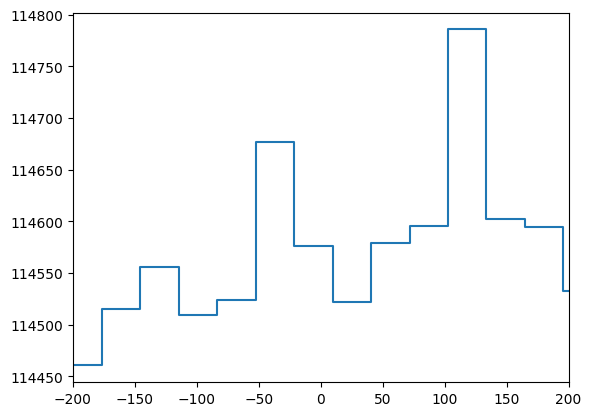

In [20]:
plt.figure()


snr = (rate-np.mean(rate))/rate_err/summary_scale['excvar']

plt.step(
    rel_s_scale,
    rate
)
plt.xlim(-200,200)
            

In [21]:
for e in all_excesses:
    if np.abs(e['scale'] - 0.05)< 0.001:
        # if np.abs(e['excess']['rel_s_scale']) < 5:
        print(e['excess']['rel_s_scale'], e)

-299.52556336065754 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.070966576816289, 'rel_s_scale': -299.52556336065754, 'rate': 119919.99999999997, 'rate_err': 1548.676854608475, 'rate_overbkg': 5338.273333333331, 'FAP': 102.69948397487316}}
-266.27553790749516 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.1609023474820317, 'rel_s_scale': -266.27553790749516, 'rate': 120079.99999999997, 'rate_err': 1549.709650224841, 'rate_overbkg': 5498.273333333331, 'FAP': 70.1416971149837}}
-261.12553181592375 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.787158505757924, 'rel_s_scale': -261.12553181592375, 'rate': 121199.99999999997, 'rate_err': 1556.9200364822848, 'rate_overbkg': 6618.273333333331, 'FAP': 13.756587839807235}}
-249.77552438504063 {'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 3.025954198593454, 'rel_s_scale': -249.77552438504063, 'rate': 119839.99999999997, 'rate_err': 1548.1601984290899, 'rate_overbkg': 5258.27333

In [22]:
grouped_excesses = []

for i in sorted(all_excesses, key=lambda x:x['excess']['FAP']):
    if i['excess']['FAP']<1 or True:
        print(i['scale'],i['offset'], i['excess']['snr'], i['excess']['rel_s_scale'], i['excess']['FAP'])
        
        grouped=False
        for g in grouped_excesses:
            if abs(i['excess']['rel_s_scale']-g['excess']['rel_s_scale'])<max(i['scale'],g['scale']):
                print("to group", g['excess']['rel_s_scale'])
                if i['excess']['snr'] > g['excess']['snr']:
                    print("group takeover")
                    g.update(i)
                grouped=True
                
        if not grouped:
            print("new group")
            #i['group']=[i]
            grouped_excesses.append(i)
        
    

1.3000000000000003 1 4.415893743982031 2.299671299316777 0.0038877872695761134
new group
1.1000000000000003 5 4.569899405659321 2.1996711919200607 0.003948820892156496
to group 2.299671299316777
group takeover
1.2500000000000002 8 4.401462689470121 2.274671280174516 0.004042211095380505
to group 2.1996711919200607
1.2500000000000002 9 4.405651984849781 2.324671317008324 0.004118245145623551
to group 2.1996711919200607
1.2500000000000002 7 4.313821065472342 2.2246712433407083 0.004229975817781743
to group 2.1996711919200607
1.1500000000000001 7 4.4020161729165705 2.224671228854593 0.004295362009773821
to group 2.1996711919200607
1.1500000000000001 6 4.35247570920038 2.1746712062335773 0.004359576069376794
to group 2.1996711919200607
1.4000000000000004 12 4.140489447231453 2.2996712978056166 0.004545469966158324
to group 2.1996711919200607
1.4000000000000004 13 4.153755926142179 2.3496713212807663 0.004585767280914108
to group 2.1996711919200607
1.3000000000000003 0 4.164214632451967 2.2

In [23]:
grouped_excesses=sorted(grouped_excesses, key=lambda x:x['excess']['FAP'])

for i in grouped_excesses:
    print(f"timescale {i['scale']:4.2f}   S/N {i['excess']['snr']:5.2f}   T0+{i['excess']['rel_s_scale']:7.1f}   FAP {i['excess']['FAP']:7.5f}")

timescale 0.10   S/N  4.61   T0+    2.0   FAP 0.03935
timescale 0.05   S/N 10.20   T0+  -30.7   FAP 0.06822
timescale 0.60   S/N  3.39   T0+   46.6   FAP 0.70233
timescale 1.85   S/N  3.21   T0+  -98.4   FAP 0.74265
timescale 1.30   S/N  3.59   T0+  179.5   FAP 0.81379
timescale 0.20   S/N  3.25   T0+  -14.3   FAP 0.90394
timescale 0.25   S/N  3.79   T0+  -57.8   FAP 0.97135
timescale 0.25   S/N  3.23   T0+  -18.6   FAP 0.98031
timescale 0.30   S/N  3.61   T0+   59.1   FAP 1.12390
timescale 0.85   S/N  3.49   T0+  138.5   FAP 1.19085
timescale 0.20   S/N  3.47   T0+  -34.4   FAP 1.31331
timescale 0.15   S/N  3.13   T0+  -12.2   FAP 1.37192
timescale 0.25   S/N  3.64   T0+  -64.4   FAP 1.40621
timescale 0.90   S/N  3.26   T0+  136.4   FAP 1.84555
timescale 0.25   S/N  3.04   T0+   23.9   FAP 2.06491
timescale 0.60   S/N  3.54   T0+  193.6   FAP 2.12832
timescale 0.20   S/N  3.72   T0+ -101.9   FAP 2.42256
timescale 0.10   S/N  3.76   T0+  -59.0   FAP 2.62725
timescale 0.70   S/N  3.46  

In [24]:
import json

len(json.dumps(grouped_excesses))

11977

In [25]:
summary['ACS']['best']

{'localfar_s': 9.321199970915421,
 'scale': 0.05000000000000001,
 'summary_scale': {'scale_s': 0.05000000000000001,
  'meanrate': 114581.72666666664,
  'maxrate': 133279.99999999997,
  'stdvar': 1699.1729611653864,
  'meanerr': 1513.814563720845,
  'excvar': 1.1224445859398684,
  'maxsnr': 10.203263552234729,
  'maxsnr_t': -30.725353391608223,
  'localfar': 1.1503186123706418e-20,
  'localfar_s': 9.321199970915421,
  'excesses': [{'snr': 3.070966576816289,
    'rel_s_scale': -299.52556336065754,
    'rate': 119919.99999999997,
    'rate_err': 1548.676854608475,
    'rate_overbkg': 5338.273333333331,
    'FAP': 102.69948397487316},
   {'snr': 3.1609023474820317,
    'rel_s_scale': -266.27553790749516,
    'rate': 120079.99999999997,
    'rate_err': 1549.709650224841,
    'rate_overbkg': 5498.273333333331,
    'FAP': 70.1416971149837},
   {'snr': 3.787158505757924,
    'rel_s_scale': -261.12553181592375,
    'rate': 121199.99999999997,
    'rate_err': 1556.9200364822848,
    'rate_overbk

In [26]:
#T

In [27]:
summary['ACS']['s_8']

{0: {'scale_s': 8.000000000000002,
  'meanrate': 114581.72666666664,
  'maxrate': 114925.99999999997,
  'stdvar': 149.6965662784406,
  'meanerr': 119.67754941229924,
  'excvar': 1.2508324828972166,
  'maxsnr': 2.2963605713699926,
  'maxsnr_t': 255.99986857114345,
  'localfar': 0.8120727536995841,
  'localfar_s': 0.237752897234948,
  'excesses': []},
 'best': {'localfar_s': 0.9667800966605067,
  'scale': 8.0,
  'summary_scale': {'scale_s': 8.000000000000002,
   'meanrate': 114581.56756756754,
   'maxrate': 114959.99999999997,
   'stdvar': 144.67774241686254,
   'meanerr': 119.67746632489319,
   'excvar': 1.2088971036878413,
   'maxsnr': 2.6113833340097528,
   'maxsnr_t': 137.1997756197925,
   'localfar': 0.3336539762784879,
   'localfar_s': 0.9667800966605067,
   'excesses': []}},
 4: {'scale_s': 8.000000000000002,
  'meanrate': 114582.5101351351,
  'maxrate': 114915.99999999997,
  'stdvar': 148.191230997574,
  'meanerr': 119.67795856753193,
  'excvar': 1.238249989984184,
  'maxsnr': 2.

In [28]:
excvar_summary=dict(
)

for k,s in summary['ACS'].items():
    if 'scale_s' in s:
        print("%.5lg"%s['scale_s'], "%5.4lg"%s['excvar'])
        
        if s['scale_s']<=0.200:
            kg='hf_200ms'
        elif s['scale_s']<=2.00:
            kg='mf_200ms_2s'
        elif s['scale_s']<=10.00:
            kg='mf_2s_10s'
        else:
            kg='lf_10s'
        
        if kg not in excvar_summary:
            excvar_summary[kg]=[s['excvar']]
        else:
            excvar_summary[kg]+=[s['excvar']]

for k,v in excvar_summary.items():
    print(k,min(v),max(v))

0.05 1.122
0.1 1.126
0.15 1.135
0.2 1.139
0.25 1.147
0.3 1.133
0.35 1.176
0.4  1.17
0.45 1.153
0.5 1.163
0.55 1.146
0.6 1.128
0.65 1.158
0.7 1.136
0.75 1.138
0.8  1.17
0.85 1.152
0.9 1.143
0.95 1.166
1  1.16
1.1 1.154
1.15 1.153
1.25 1.168
1.3 1.177
1.4  1.16
1.5 1.193
1.6 1.159
1.7  1.17
1.85 1.127
1.95 1.132
2 1.171
2.1 1.156
2.25 1.123
2.4 1.158
2.5 1.148
2.55 1.163
2.7 1.074
2.9 1.172
3 1.187
3.1 1.172
3.3 1.196
3.5 1.069
3.55 1.089
3.75 1.119
4 1.041
4.3 1.149
4.5 1.154
4.6 1.118
4.9 1.073
5 1.044
5.2 1.163
5.5 1.141
5.55  1.08
5.95 1.139
6 1.169
6.35 1.132
6.5 1.059
6.75 1.181
7 1.098
7.2 1.137
7.5 1.126
7.7 1.107
8 1.209
8.2 1.141
8.5 1.068
8.75 1.145
9 1.206
9.35 1.166
9.5 1.132
10 1.081
10.5  1.19
10.65 1.057
11 1.241
11.35 1.064
11.5 1.162
12 1.146
12.1 1.138
12.5  1.18
12.95 1.185
13 1.075
13.5 1.226
13.8 1.104
14 1.054
14.5 1.169
14.7 1.252
15 1.014
15.5 0.9895
15.7 1.108
16 1.156
16.5 0.9915
16.75 1.076
17 1.114
17.5 1.248
17.85 0.933
18 0.9473
18.5 0.9878
19 1.023
19.05 1

total lc (12000, 4)
min -0.003471939381597622
max 0.00347193173274718
total lc (12000, 4)
min -0.003471939381597622
max 0.00347193173274718
{'scale': 0.10000000000000002, 'offset': 0, 'excess': {'snr': 4.613253455115865, 'rel_s_scale': 2.049671101849526, 'rate': 120279.99999999997, 'rate_err': 1096.7223896684154, 'rate_overbkg': 5698.273333333331, 'FAP': 0.03934724088359115}}
(-2.0, 2.0)
{'scale': 0.05000000000000001, 'offset': 0, 'excess': {'snr': 10.203263552234729, 'rel_s_scale': -30.725353391608223, 'rate': 133279.99999999997, 'rate_err': 1632.6665305566837, 'rate_overbkg': 18698.27333333333, 'FAP': 0.06821770385679067}}
(-2.0, 2.0)
total lc (12000, 4)
min -0.003471939381597622
max 0.00347193173274718
{'scale': 0.10000000000000002, 'offset': 0, 'excess': {'snr': 4.613253455115865, 'rel_s_scale': 2.049671101849526, 'rate': 120279.99999999997, 'rate_err': 1096.7223896684154, 'rate_overbkg': 5698.273333333331, 'FAP': 0.03934724088359115}}
(-2.0, 2.0)
{'scale': 0.05000000000000001, 'of

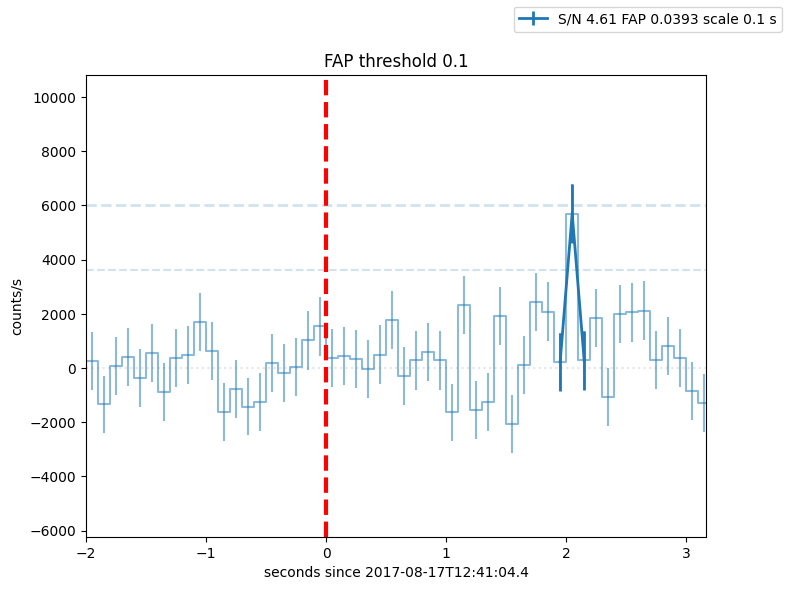

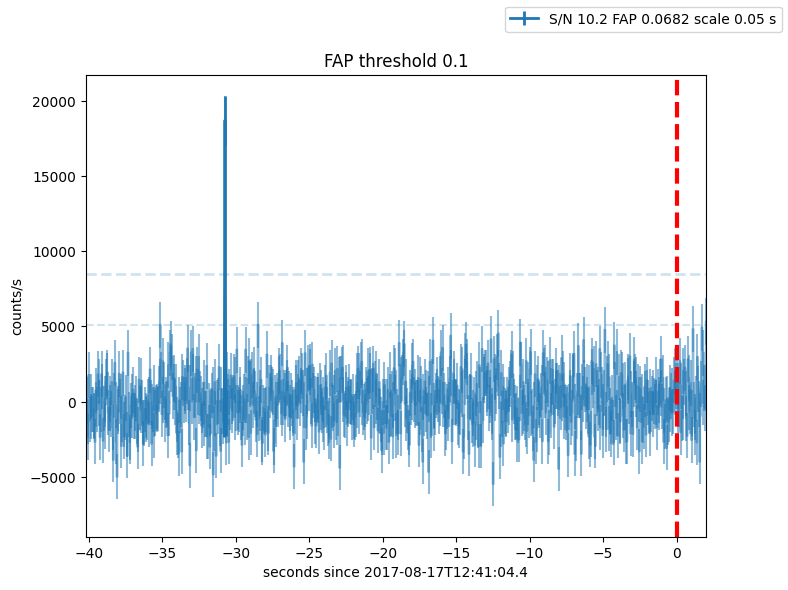

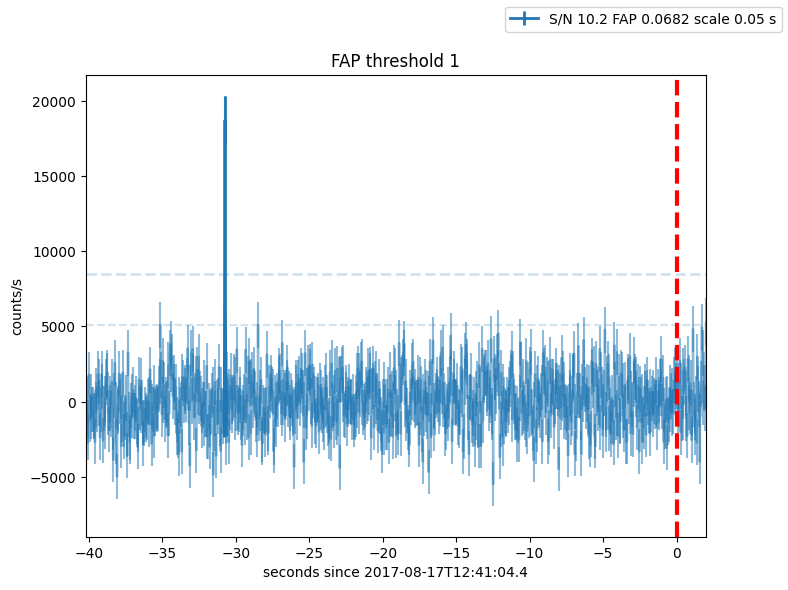

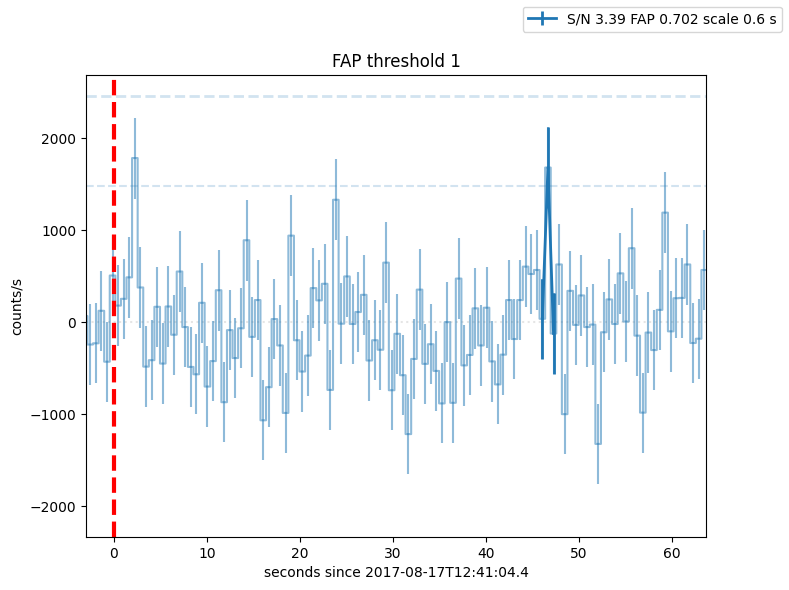

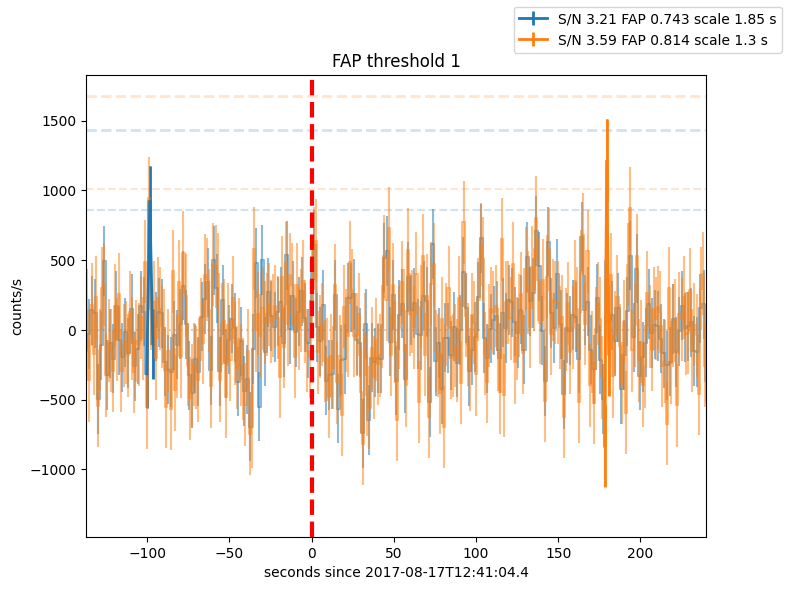

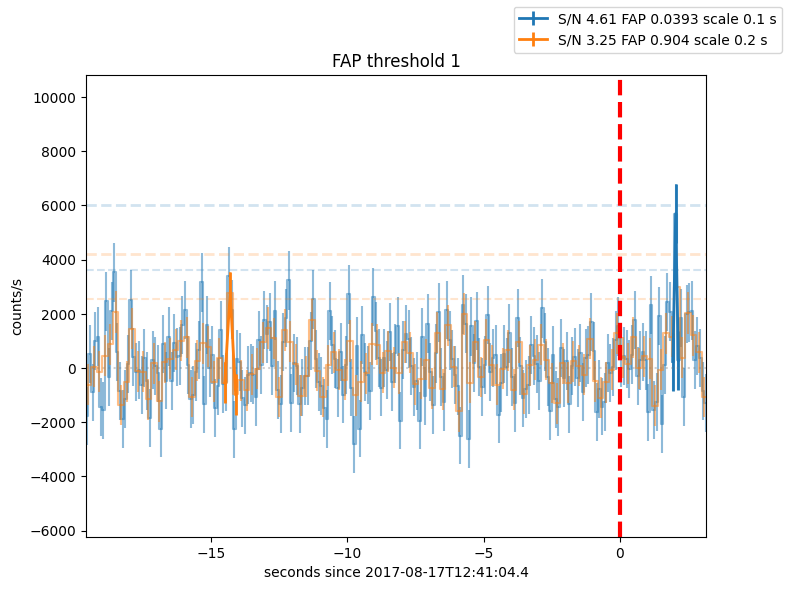

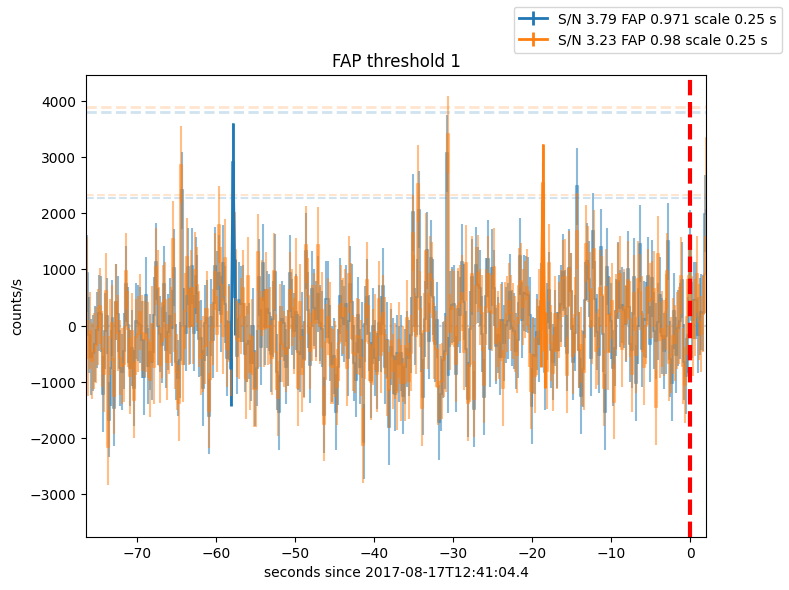

In [29]:
fig_names=[]


for limit_group in 0.02, 0.1, 1: 
    figs=dict()

    for n, lc in lcs.items():
        rel_s = (lc[:,0]-t0_ijd)*24*3600

        m = rel_s>-tstart_rel_mseconds
        m &= rel_s<tstop_rel_seconds

        print("total lc",lc.shape)
        print("min",lc[:,0].min()-t0_ijd)
        print("max",lc[:,0].max()-t0_ijd)

        lc = lc[m]
        rel_s = rel_s[m]

        for excess in grouped_excesses:
            #if excess['excess']['FAP'] > 0.02: continue
            if excess['excess']['FAP'] > limit_group: continue

            print(excess)


            offset = excess['offset']
            nscale = int(excess['scale']/b_tb)  
            scale=excess['scale']

            s_figs = sorted(figs.items(), key=lambda x:abs(x[0]-scale))

            if len(s_figs) == 0 or s_figs[0][0] < scale*0.5 or s_figs[0][0] > scale*1.5: 
                fig = pylab.figure(figsize=(8,6))
                figs[scale] = fig
                pylab.xlim([-2,2])
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")
                pylab.title("FAP threshold %.5lg"%limit_group)
            else:            
                print("good match", s_figs[0][0], scale)
                pylab.figure(s_figs[0][1].number)
                pylab.xlabel("seconds since "+t0_utc)
                pylab.ylabel("counts/s")



            rel_s_scale = rebin(rel_s[offset:],nscale,True)
            rate = rebin(lc[offset:,2],nscale,False)/scale        
            rate_err = rebin(lc[offset:,2],nscale,False)**0.5/scale

            bkg=np.mean(rate)

            m_on = np.abs(rel_s_scale-excess['excess']['rel_s_scale'])<excess['scale']*1.5


            pylab.grid(False)

            pylab.axhline(0, alpha=0.2, ls=":", color='gray')

            cr=pylab.errorbar(
                    rel_s_scale, 
                    (rate-bkg), 
                    (rate_err),
                    alpha=0.5,
                    ls="",
                )[0].get_color()

            pylab.step(
                    rel_s_scale, 
                    (rate-bkg), 
              #      (rate_err),
                    alpha=0.5,
                    where="mid",
                    c=cr,
                )

            pylab.axhline(np.std(rate)*3, alpha=0.2, ls="--",c=cr)
            pylab.axhline(np.std(rate)*5, alpha=0.2, ls="--", lw=2,c=cr)






            pylab.errorbar(
                    rel_s_scale[m_on], 
                    (rate-bkg)[m_on], 
                    (rate_err)[m_on],
                    lw=2.,
                    alpha=1,
                    label="S/N %.3lg FAP %.3lg scale %.3lg s"%(excess['excess']['snr'],excess['excess']['FAP'],excess['scale']),
                    c=cr
                )



            newlim=([
                min([excess['excess']['rel_s_scale']*1.3-excess['scale']*5,-excess['scale']*5]),
                max([excess['excess']['rel_s_scale']*1.3+excess['scale']*5,excess['scale']*5]),
            ])

            oldlim=pylab.gca().get_xlim()

            print(oldlim)

            pylab.xlim([
                min([oldlim[0],newlim[0]]),
                max([oldlim[1],newlim[1]]),
            ])


    for f_i,(s,f) in enumerate(figs.items()):
        f.legend()
        f.gca().axvline(0,ls="--",c="r",lw=3)
        fn="excess_%.5lg_%i.png"%(s,len(fig_names))
        f.savefig(fn)
        fig_names.append(fn)






axes [<Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: > <Axes: >] <class 'numpy.ndarray'>


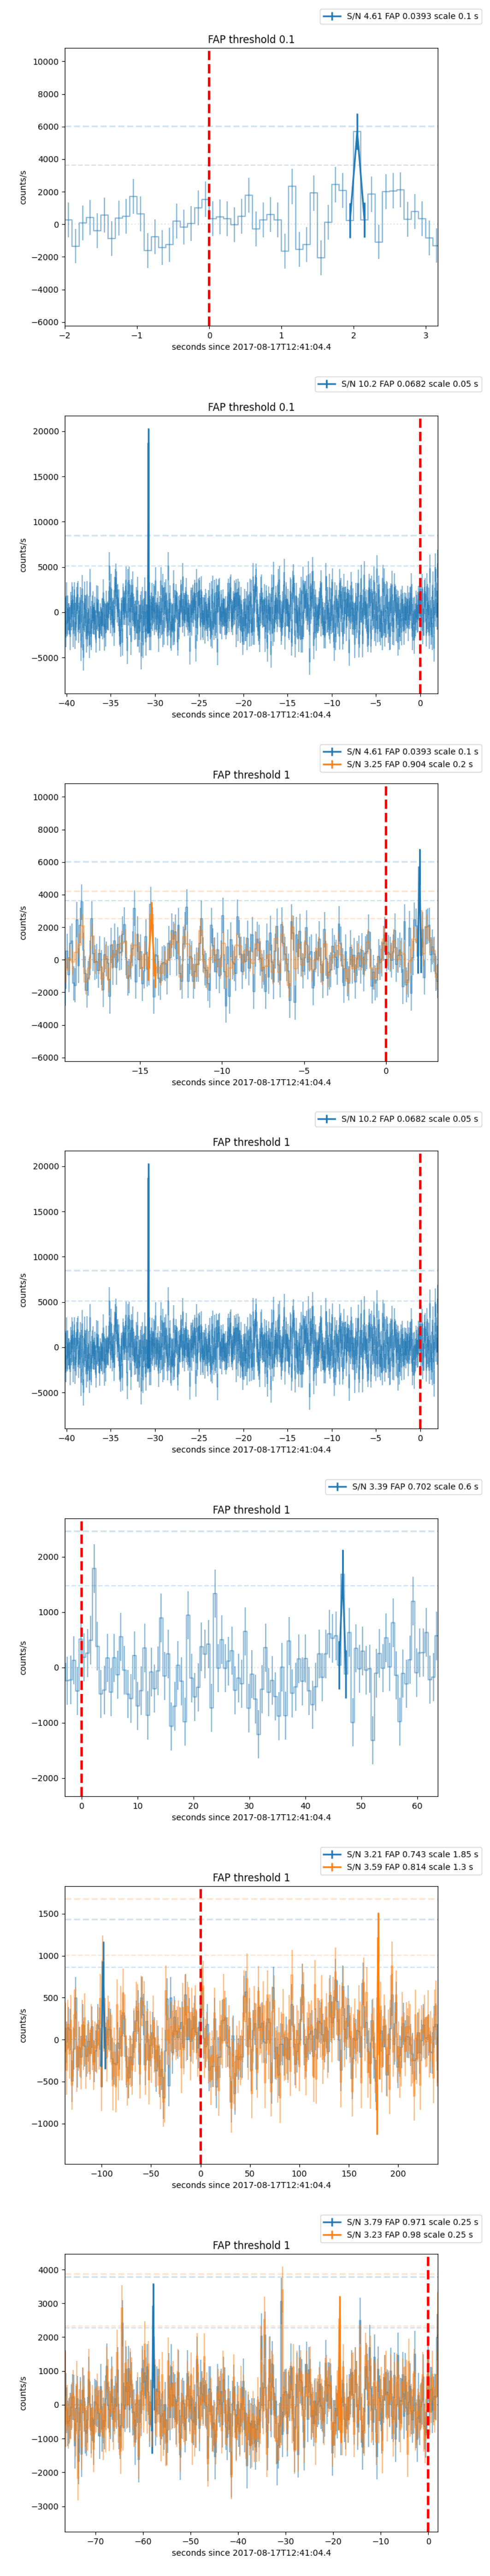

In [30]:
cols=1
rows=int(np.ceil(len(fig_names)/cols))


if rows>0:
    f, axes=pylab.subplots(rows, cols, figsize=(12, 8*rows))
    print("axes",axes,axes.__class__)

    if rows>1:
        axes=axes.flatten()
    else:
        axes=[axes]

    for i,fn in enumerate(fig_names):
        #f.add_subplot(len(fig_names), 2, i+1)
        axes[i].axis('off')
        axes[i].imshow(pylab.imread(fn) ) #, extent=(0,1,0,1))
        #pylab.imshow(pylab.imread(fn), extent=(0,1,(i-1)/len(fig_names),i/len(fig_names)))

    f.tight_layout()
else:
    f=pylab.figure()

f.savefig("excesses_mosaic.png")

In [31]:
if rt == 1:    
    summary['ACS_rt'] = summary['ACS']

In [32]:
summary['ACS']['s_1']['meanerr']

338.49922698089966

In [33]:
import json

json.dump(dict(
    summary=summary,
    reportable_excesses=grouped_excesses,
    excvar_summary=excvar_summary
), open("integral_all_sky.json","w"), indent=4)

In [34]:
acs_lc_png="ACS_lc.png"
acs_rt_lc_png="ACS_lc.png"
acs_rt_det_lc_png="ACS_det_lc.png"
ibis_veto_lc_png="IBIS_Veto_lc.png"
excesses_mosaic_png="excesses_mosaic.png"
summary=summary
reportable_excesses=grouped_excesses
excvar_summary=excvar_summary